# Breast Cancer Classification Using CNNs
### By: Eduardo Olmos

**Used the Keras tutorial from https://www.tensorflow.org/tutorials/images/classification**

**NOTE:**  This project was conducted in Google Colabs PRO.  To reproduce, open this file within the Google Colabs environment.  You will also need to add the dataset included in the repo to the same Google Drive where you are running the  Colab.  Then mount your Drive within Google Colabs so you can access the dataset.  If your local system can run Keras, feel free to change the file paths and proceed as required.

## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from pathlib import Path

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os

## Build Training and Validation Datasets

In [3]:
## create Path object to where the BUSI Dataset is within Google Drive
data_dir = Path('drive/MyDrive/datasets')

In [4]:
## Create a list of all heights and widths of PNGs
image_sizes = [PIL.Image.open(image_path).size for image_path in list(data_dir.glob('*/*.png'))]

In [5]:
## Separate widths and heights into separate lists
img_widths = []
img_heights = []
for size in image_sizes:
  img_widths.append(size[0])
  img_heights.append(size[1])

In [6]:
## Calculate max width and height
max_width = np.max(img_widths)
max_height = np.max(img_heights)

print(max_width)
print(max_height)

1048
719


In [7]:
##Calculate min width and height
min_width = np.min(img_widths)
min_height = np.min(img_heights)

print(min_width)
print(min_height)

190
310


In [8]:
## Calculate average width and height rounded to nearest 5
## These are the dimensions I proceeded with due to preliminary results and performance 
avg_width = 5 * round(np.mean(img_widths) / 5)
avg_height = 5 * round(np.mean(img_heights) / 5)

print(avg_height)
print(avg_width)

## https://www.kite.com/python/answers/how-to-round-to-the-nearest-multiple-of-5-in-python

500
615


In [9]:
## Make sure all images are being read minus the 3 taken out for testing
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

777


In [10]:
## Define batch size and height and width to resize images
batch_size = 32
img_height = avg_height
img_width = avg_width

In [11]:
## Create training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.15,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 777 files belonging to 3 classes.
Using 661 files for training.


In [12]:
## Create validation dataset 
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.15,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 777 files belonging to 3 classes.
Using 116 files for validation.


## Check Data Within Newly Created Datasets

In [13]:
## Extract class names
class_names = train_ds.class_names
print(class_names)

['benign', 'malignant', 'normal']


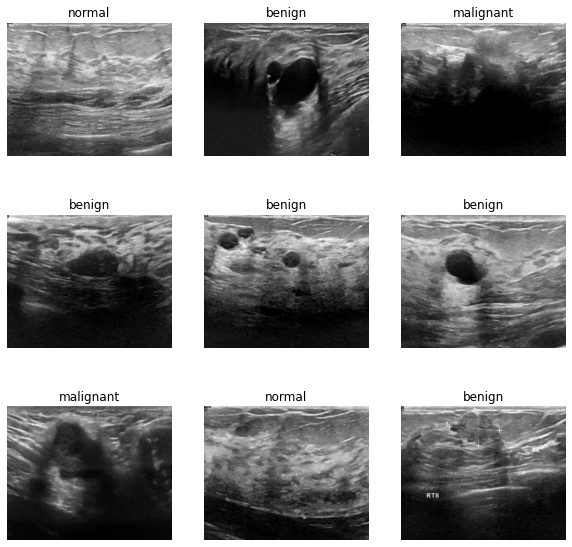

In [14]:
## Show the first 9 images from training dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [15]:
##Check a single image batch shape
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 500, 615, 3)
(32,)


Build the Model

In [16]:
## How many classes? 
num_classes = 3

## Build preliminary model 
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(filters=32, kernel_size=3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(filters=64, kernel_size=3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(filters=128, kernel_size=3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the Model

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 500, 615, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 498, 613, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 249, 306, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 304, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 123, 152, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 150, 128)     7

## Train the Model

In [19]:
epochs= 10
history = model.fit(
 train_ds,
 validation_data=val_ds,
 epochs=epochs
)

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Refine the Model

In [21]:
## Create augmentation model
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

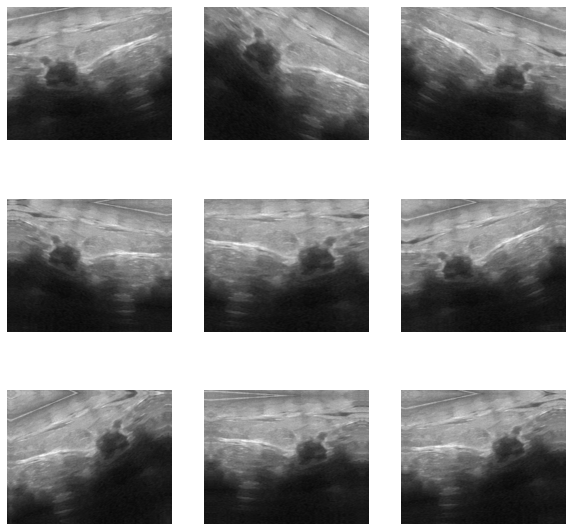

In [22]:
## View what one image looks like augmented
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [31]:
## Build model with augmentation and dropout layers added and hyperparameters adjusted
num_classes = 3

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(filters= 16, kernel_size= 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(filters= 16, kernel_size= 4, dilation_rate= 2, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(filters= 64, kernel_size= 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(filters= 64, kernel_size= 4, dilation_rate= 2, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes)
])

In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 500, 615, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 500, 615, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 500, 615, 16)      784       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 250, 307, 16)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 250, 307, 16)      4112      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 125, 153, 16)     0         
 2D)                                                  

In [34]:
## Train with 200 epochs
epochs = 200
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/200
21/21 [==============================] - 8s 262ms/step - loss: 1.0997 - accuracy: 0.5280 - val_loss: 0.9466 - val_accuracy: 0.6121
Epoch 2/200
21/21 [==============================] - 7s 257ms/step - loss: 0.9674 - accuracy: 0.5522 - val_loss: 0.9223 - val_accuracy: 0.6121
Epoch 3/200
21/21 [==============================] - 7s 252ms/step - loss: 0.9274 - accuracy: 0.5537 - val_loss: 0.8989 - val_accuracy: 0.6121
Epoch 4/200
21/21 [==============================] - 7s 252ms/step - loss: 0.8893 - accuracy: 0.5900 - val_loss: 0.8331 - val_accuracy: 0.6638
Epoch 5/200
21/21 [==============================] - 7s 250ms/step - loss: 0.8772 - accuracy: 0.6203 - val_loss: 0.9342 - val_accuracy: 0.6552
Epoch 6/200
21/21 [==============================] - 7s 251ms/step - loss: 0.9118 - accuracy: 0.5991 - val_loss: 0.8171 - val_accuracy: 0.6724
Epoch 7/200
21/21 [==============================] - 7s 250ms/step - loss: 0.8620 - accuracy: 0.6188 - val_loss: 0.8965 - val_accuracy: 0.6121

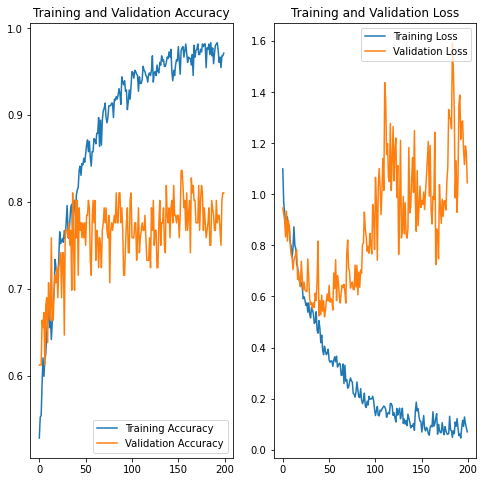

In [35]:
## View results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Test the Model

In [36]:
## Make a prediction for a malignant PNG
malignant_path = Path('drive/MyDrive/test_data/malignant (1).png')

img = tf.keras.utils.load_img(
    malignant_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to malignant with a 95.11 percent confidence.


In [37]:
## Make a predicition for benign PNG
benign_path = Path('drive/MyDrive/test_data/benign (1).png')

img = tf.keras.utils.load_img(
    benign_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to benign with a 100.00 percent confidence.


In [38]:
## Make prediciton for a normal PNG
normal_path = Path('drive/MyDrive/test_data/normal (1).png')

img = tf.keras.utils.load_img(
    normal_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to benign with a 93.53 percent confidence.
